# Food Classification using Transfer Learning

Building a CNN classifier for Food-101 dataset using transfer learning with EfficientNetB4 pretrained on ImageNet. The base model is frozen and we train only new classification layers for 101 food categories. https://www.kaggle.com/datasets/dansbecker/food-101

## Google Colab setup
Run this cell first if you run on Colab. If you don't do the training in Colab, skip this cell.
https://colab.research.google.com

In [ ]:
import os

try:
    from google.colab import drive
    drive.mount("/content/drive")
    # Put BASE_DIR to your project folder on Drive (e.g. smartfood).
    # If you cloned the repo: BASE_DIR = "/content/smartfood"
    BASE_DIR = "/content/drive/MyDrive/smartfood"
    print("Colab: Drive monterat. BASE_DIR =", BASE_DIR)
except ImportError:
    BASE_DIR = None
    print("Körs inte i Colab – BASE_DIR sätts i Configuration nedan.")

## Install Tensorflow for google colab

In [ ]:
!pip install tensorflow tensorflow-datasets

## Setup and GPU Configuration
If you run the training on UBUNTU (Linux), it's configured to automatically use the PC's GPU.     
OBS! On the other hand you can't configure tensorflow to use the PC's GPU directly on Windows.

In [ ]:
import os
import json
import numpy as np
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

print(f"TensorFlow version: {tf.__version__}")


# Configure GPU memory growth to avoid OOM errors
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    print(f"GPU detected: {gpus[0].name}")
    # Enable mixed precision for faster training
    tf.keras.mixed_precision.set_global_policy('mixed_float16')
    print("Mixed precision enabled")
else:
    print("No GPU detected, using CPU")

2026-02-02 17:19:37.006542: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-02 17:19:37.722012: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1770049177.950219  147798 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1770049178.017632  147798 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1770049178.608844  147798 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

TensorFlow version: 2.19.0
GPU detected: /physical_device:GPU:0, 8 GB allocated for training
Mixed precision enabled


## Configuration

In [2]:
# Hyperparameters
IMAGE_SIZE = (224, 224)  # EfficientNetB4 input size
BATCH_SIZE = 32  # Standard batch size for stable training
EPOCHS = 60
LEARNING_RATE = 2e-3
VALIDATION_SPLIT = 0.15

# Paths
if "BASE_DIR" not in dir() or BASE_DIR is None:
    BASE_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
MODEL_DIR = os.path.join(BASE_DIR, 'data', 'models', 'cnn')
os.makedirs(MODEL_DIR, exist_ok=True)

print(f"Model will be saved to: {MODEL_DIR}")

Model will be saved to: /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn


## Load Food-101 Dataset

Food-101 contains 101,000 images across 101 food categories (750 training + 250 test images per class).

In [3]:
(ds_train, ds_test), ds_info = tfds.load(
    'food101',
    split=['train', 'validation'],
    as_supervised=True,
    with_info=True
)

NUM_CLASSES = ds_info.features['label'].num_classes
class_names = ds_info.features['label'].names

print(f"Number of classes: {NUM_CLASSES}")
print(f"Training samples: {ds_info.splits['train'].num_examples}")
print(f"Test samples: {ds_info.splits['validation'].num_examples}")

I0000 00:00:1770049195.228638  147798 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 8192 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4070 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Number of classes: 101
Training samples: 75750
Test samples: 25250


## Sample Images from Dataset

Display example images to visualize the data.

2026-02-02 17:19:56.127491: I tensorflow/core/kernels/data/tf_record_dataset_op.cc:387] The default buffer size is 262144, which is overridden by the user specified `buffer_size` of 8388608
2026-02-02 17:19:56.414330: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


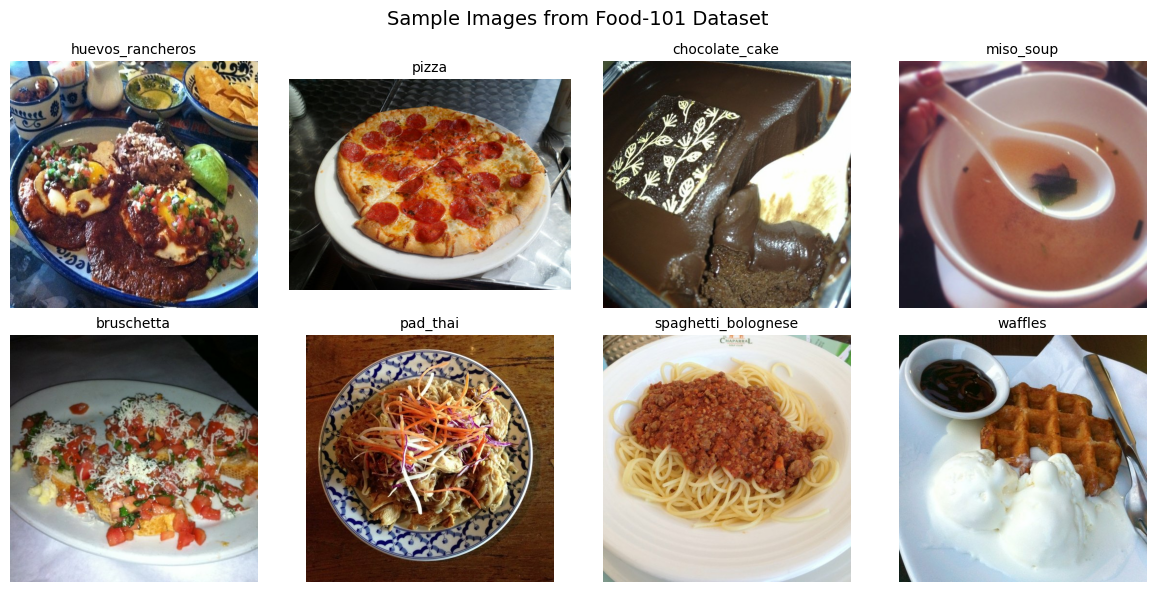

In [4]:
import matplotlib.pyplot as plt

# Show 8 sample images from training set
plt.figure(figsize=(12, 6))
for i, (image, label) in enumerate(ds_train.take(8)):
    plt.subplot(2, 4, i + 1)
    plt.imshow(image.numpy().astype('uint8'))
    plt.title(class_names[label.numpy()], fontsize=10)
    plt.axis('off')
plt.suptitle('Sample Images from Food-101 Dataset', fontsize=14)
plt.tight_layout()
plt.show()

## Data Preprocessing

Resize images to mean/std per channel, normalize to [0, 1], and apply data augmentation to training set.

In [5]:
# IMPORTANT: EfficientNetB4 requires its own preprocessing function
# Cannot use simple /255.0 normalization because the model was trained with
# specific ImageNet normalization (mean/std per channel)
# Using wrong normalization leads to ~1% accuracy (random guessing)

def preprocess_train(image, label):
    # Resize to model input size
    image = tf.image.resize(image, IMAGE_SIZE)
    
    # Data augmentation (applied on [0, 255] range)
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_brightness(image, 0.1)
    image = tf.image.random_contrast(image, 0.9, 1.1)
    
    # Apply EfficientNet-specific preprocessing (scales and normalizes)
    image = preprocess_input(image)
    return image, label

def preprocess_test(image, label):
    # Resize to model input size
    image = tf.image.resize(image, IMAGE_SIZE)
    
    # Apply EfficientNet-specific preprocessing
    image = preprocess_input(image)
    return image, label

# Split training set into train and validation
train_size = ds_info.splits['train'].num_examples
val_size = int(train_size * VALIDATION_SPLIT)

ds_train = ds_train.shuffle(10000, seed=42)
ds_val = ds_train.take(val_size)
ds_train = ds_train.skip(val_size)

# Prepare datasets with preprocessing and batching
train_dataset = ds_train.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = ds_val.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

test_dataset = ds_test.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

print("Datasets prepared")

Datasets prepared


## Build Transfer Learning Model

Load pretrained EfficientNetB4 and freeze base layers. Add new classification head for 101 food categories.

In [6]:
# Load pretrained model without top classification layer
base_model = EfficientNetB4(
    weights='imagenet',
    include_top=False,
    input_shape=IMAGE_SIZE + (3,),
    pooling='avg'  # Global average pooling
)

# Freeze base model layers - we only train the new layers
base_model.trainable = False

# Build model with Sequential API
model = Sequential([
    base_model,
    layers.Dropout(0.3),
    layers.Dense(1024, activation='relu'),
    layers.Dropout(0.15),
    layers.Dense(NUM_CLASSES, activation='softmax', dtype='float32')  # Output layer
])

model.summary()

2026-02-02 17:19:58.105715: E tensorflow/core/util/util.cc:131] oneDNN supports DT_HALF only on platforms with AVX-512. Falling back to the default Eigen-based implementation if present.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb4 (Functional)     │ (None, 1792)           │    17,673,823 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1792)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1024)           │     1,836,032 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 101)            │       103,525 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 19,613,380 (74.82 MB)

 Trainable params: 1,939,557 (7.40 MB)

 Non-trainable params: 17,673,823 (67.42 MB)

## Compile Model

In [7]:
model.compile(
    optimizer=keras.optimizers.Adam(LEARNING_RATE),
    loss='sparse_categorical_crossentropy',  # Integer labels (not one-hot)
    metrics=['accuracy']
)

print("Model compiled")

Model compiled


## Train Model

Train with early stopping and learning rate reduction callbacks.

In [ ]:
# Define callbacks
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=8,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.3,
        patience=3,
        min_lr=1e-7,
        verbose=1
    ),
    ModelCheckpoint(
        os.path.join(MODEL_DIR, 'food_classifier_best.keras'),
        monitor='val_accuracy',
        save_best_only=True,
        verbose=1
    )
]

# Train model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=callbacks,
    verbose=1
)

# Save training history
with open(os.path.join(MODEL_DIR, 'training_history.json'), 'w') as f:
    json.dump({k: [float(v) for v in vals] for k, vals in history.history.items()}, f, indent=2)

print("Training complete")

Epoch 1/60


I0000 00:00:1770049221.179265  147953 service.cc:152] XLA service 0x7fe7f8013be0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1770049221.179335  147953 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 4070 Laptop GPU, Compute Capability 8.9
2026-02-02 17:20:21.904951: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1770049225.170545  147953 cuda_dnn.cc:529] Loaded cuDNN version 91801
2026-02-02 17:20:29.708889: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24281', 164 bytes spill stores, 164 bytes spill loads

2026-02-02 17:20:29.963272: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fu

2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.4152 - loss: 2.3826

2026-02-02 17:22:29.856845: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24419', 324 bytes spill stores, 324 bytes spill loads

2026-02-02 17:22:30.013205: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24516', 536 bytes spill stores, 536 bytes spill loads

2026-02-02 17:22:30.098583: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24281', 156 bytes spill stores, 156 bytes spill loads

2026-02-02 17:22:30.564928: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24281', 1016 bytes spill stores, 1016 bytes spill loads

2026-02-02 17:22:30.969132

2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.4152 - loss: 2.3825

2026-02-02 17:23:11.555231: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4469', 36 bytes spill stores, 36 bytes spill loads

2026-02-02 17:23:11.970173: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4461', 248 bytes spill stores, 248 bytes spill loads

2026-02-02 17:23:12.106705: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4469', 180 bytes spill stores, 180 bytes spill loads

2026-02-02 17:23:12.111993: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_4469', 1292 bytes spill stores, 1292 bytes spill loads

2026-02-02 17:23:12.693171: I ex


Epoch 1: val_accuracy improved from None to 0.57076, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 1: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 255s 87ms/step - accuracy: 0.4699 - loss: 2.1192 - val_accuracy: 0.5708 - val_loss: 1.6707 - learning_rate: 0.0020
Epoch 2/60


2026-02-02 17:24:20.687384: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step - accuracy: 0.5401 - loss: 1.8343
Epoch 2: val_accuracy improved from 0.57076 to 0.59972, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 2: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 142s 69ms/step - accuracy: 0.5430 - loss: 1.8167 - val_accuracy: 0.5997 - val_loss: 1.5613 - learning_rate: 0.0020
Epoch 3/60


2026-02-02 17:27:01.639716: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 17:27:03.954396: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step - accuracy: 0.5559 - loss: 1.7510

2026-02-02 17:31:12.810347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 17:31:38.894893: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2368 of 10000
2026-02-02 17:31:48.988340: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 4947 of 10000
2026-02-02 17:32:05.098269: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7734 of 10000
2026-02-02 17:32:08.350690: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 3: val_accuracy improved from 0.59972 to 0.60914, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 3: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 415s 193ms/step - accuracy: 0.5613 - loss: 1.7244 - val_accuracy: 0.6091 - val_loss: 1.5297 - learning_rate: 0.0020
Epoch 4/60


2026-02-02 17:33:48.592291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 33 of 10000
2026-02-02 17:33:59.861059: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 17:34:14.713487: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step - accuracy: 0.5715 - loss: 1.6943

2026-02-02 17:36:08.246918: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 4: val_accuracy improved from 0.60914 to 0.61530, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 4: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 166s 63ms/step - accuracy: 0.5756 - loss: 1.6721 - val_accuracy: 0.6153 - val_loss: 1.5190 - learning_rate: 0.0020
Epoch 5/60


2026-02-02 17:36:25.764040: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.5822 - loss: 1.6671

2026-02-02 17:37:41.567242: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 4429 of 10000
2026-02-02 17:37:43.385684: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 5: val_accuracy improved from 0.61530 to 0.62489, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 5: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 122s 58ms/step - accuracy: 0.5874 - loss: 1.6287 - val_accuracy: 0.6249 - val_loss: 1.4726 - learning_rate: 0.0020
Epoch 6/60


2026-02-02 17:38:33.636772: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 8138 of 10000
2026-02-02 17:38:34.394637: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.5846 - loss: 1.6396

2026-02-02 17:41:18.986247: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 17:41:36.880678: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 17:41:42.893626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 6: val_accuracy improved from 0.62489 to 0.64038, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 6: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 233s 107ms/step - accuracy: 0.5931 - loss: 1.5977 - val_accuracy: 0.6404 - val_loss: 1.4203 - learning_rate: 0.0020
Epoch 7/60


2026-02-02 17:42:25.968098: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2601 of 10000
2026-02-02 17:42:28.226839: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step - accuracy: 0.5935 - loss: 1.6295

2026-02-02 17:44:52.634297: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 17:45:08.414060: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5143 of 10000
2026-02-02 17:45:14.462730: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 17:45:18.149122: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 7: val_accuracy improved from 0.64038 to 0.64592, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 7: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 213s 98ms/step - accuracy: 0.6037 - loss: 1.5732 - val_accuracy: 0.6459 - val_loss: 1.3997 - learning_rate: 0.0020
Epoch 8/60


2026-02-02 17:45:59.791763: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5143 of 10000
2026-02-02 17:46:06.289323: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6005 - loss: 1.5957

2026-02-02 17:48:50.776211: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 3 of 10000
2026-02-02 17:48:53.775424: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 33 of 10000
2026-02-02 17:49:06.093394: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2356 of 10000
2026-02-02 17:49:16.890245: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5132 of 10000
2026-02-02 17:49:24.234103: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 17:49:25.267758: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This al


Epoch 8: val_accuracy did not improve from 0.64592
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 236s 104ms/step - accuracy: 0.6090 - loss: 1.5479 - val_accuracy: 0.6459 - val_loss: 1.3970 - learning_rate: 0.0020
Epoch 9/60


2026-02-02 17:49:55.502031: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.6035 - loss: 1.5703
Epoch 9: val_accuracy improved from 0.64592 to 0.65649, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 9: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 163s 76ms/step - accuracy: 0.6132 - loss: 1.5205 - val_accuracy: 0.6565 - val_loss: 1.3698 - learning_rate: 0.0020
Epoch 10/60


2026-02-02 17:52:35.169329: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6077 - loss: 1.5771

2026-02-02 17:53:43.574757: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 10: val_accuracy did not improve from 0.65649
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 92s 42ms/step - accuracy: 0.6168 - loss: 1.5153 - val_accuracy: 0.6458 - val_loss: 1.3882 - learning_rate: 0.0020
Epoch 11/60


2026-02-02 17:54:14.317967: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5132 of 10000
2026-02-02 17:54:16.329780: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 17:54:20.761379: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step - accuracy: 0.6122 - loss: 1.5790

2026-02-02 17:57:21.823866: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 49 of 10000
2026-02-02 17:57:38.775849: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5167 of 10000
2026-02-02 17:57:47.079921: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 11: val_accuracy improved from 0.65649 to 0.65763, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 11: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 262s 120ms/step - accuracy: 0.6223 - loss: 1.4995 - val_accuracy: 0.6576 - val_loss: 1.3552 - learning_rate: 0.0020
Epoch 12/60


2026-02-02 17:58:33.371926: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5235 of 10000
2026-02-02 17:58:35.536186: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step - accuracy: 0.6185 - loss: 1.5482
Epoch 12: val_accuracy did not improve from 0.65763
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 131s 58ms/step - accuracy: 0.6301 - loss: 1.4743 - val_accuracy: 0.6572 - val_loss: 1.3518 - learning_rate: 0.0020
Epoch 13/60


2026-02-02 18:00:40.442779: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2011/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.6196 - loss: 1.5582
Epoch 13: val_accuracy improved from 0.65763 to 0.66335, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 13: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 113s 53ms/step - accuracy: 0.6284 - loss: 1.4879 - val_accuracy: 0.6634 - val_loss: 1.3357 - learning_rate: 0.0020
Epoch 14/60


2026-02-02 18:02:38.074939: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2601 of 10000
2026-02-02 18:02:54.601040: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7800 of 10000
2026-02-02 18:02:55.006310: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:02:59.155026: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - accuracy: 0.6222 - loss: 1.5364

2026-02-02 18:05:15.608284: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 17 of 10000
2026-02-02 18:05:35.102213: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7766 of 10000
2026-02-02 18:05:38.313754: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:05:41.659774: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 14: val_accuracy improved from 0.66335 to 0.66546, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 14: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 228s 97ms/step - accuracy: 0.6347 - loss: 1.4576 - val_accuracy: 0.6655 - val_loss: 1.3222 - learning_rate: 0.0020
Epoch 15/60


2026-02-02 18:06:27.736028: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5143 of 10000
2026-02-02 18:06:31.728370: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:06:52.010991: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.6214 - loss: 1.5376
Epoch 15: val_accuracy did not improve from 0.66546
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 125s 44ms/step - accuracy: 0.6359 - loss: 1.4462 - val_accuracy: 0.6627 - val_loss: 1.3151 - learning_rate: 0.0020
Epoch 16/60
   1/2013 ━━━━━━━━━━━━━━━━━━━━ 2:34:20 5s/step - accuracy: 0.4375 - loss: 2.1323

2026-02-02 18:08:24.883277: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6234 - loss: 1.5333

2026-02-02 18:11:12.146346: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 18:11:29.187560: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 4699 of 10000
2026-02-02 18:11:42.944648: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 16: val_accuracy did not improve from 0.66546
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 245s 120ms/step - accuracy: 0.6386 - loss: 1.4506 - val_accuracy: 0.6612 - val_loss: 1.3201 - learning_rate: 0.0020
Epoch 17/60


2026-02-02 18:12:36.017665: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 33 of 10000
2026-02-02 18:12:50.516488: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5167 of 10000
2026-02-02 18:12:56.001455: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6240 - loss: 1.5309
Epoch 17: val_accuracy improved from 0.66546 to 0.67383, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 17: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 123s 39ms/step - accuracy: 0.6386 - loss: 1.4426 - val_accuracy: 0.6738 - val_loss: 1.2747 - learning_rate: 0.0020
Epoch 18/60


2026-02-02 18:14:34.926865: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step - accuracy: 0.6315 - loss: 1.5154

2026-02-02 18:15:43.672145: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 18: val_accuracy improved from 0.67383 to 0.67471, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 18: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 92s 42ms/step - accuracy: 0.6437 - loss: 1.4369 - val_accuracy: 0.6747 - val_loss: 1.2722 - learning_rate: 0.0020
Epoch 19/60


2026-02-02 18:16:20.287419: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6288 - loss: 1.5289

2026-02-02 18:19:06.808441: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 33 of 10000
2026-02-02 18:19:21.981229: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 5196 of 10000
2026-02-02 18:19:27.693179: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.



Epoch 19: val_accuracy improved from 0.67471 to 0.67647, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 19: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 251s 115ms/step - accuracy: 0.6430 - loss: 1.4415 - val_accuracy: 0.6765 - val_loss: 1.2594 - learning_rate: 0.0020
Epoch 20/60


2026-02-02 18:20:38.769728: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 18:20:44.722996: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 17 of 10000
2026-02-02 18:20:47.584291: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6347 - loss: 1.5049
Epoch 20: val_accuracy improved from 0.67647 to 0.67981, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 20: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 121s 41ms/step - accuracy: 0.6481 - loss: 1.4215 - val_accuracy: 0.6798 - val_loss: 1.2550 - learning_rate: 0.0020
Epoch 21/60


2026-02-02 18:22:18.667314: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6381 - loss: 1.4927
Epoch 21: val_accuracy did not improve from 0.67981
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 93s 43ms/step - accuracy: 0.6505 - loss: 1.4101 - val_accuracy: 0.6779 - val_loss: 1.2502 - learning_rate: 0.0020
Epoch 22/60


2026-02-02 18:23:57.419141: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 49 of 10000
2026-02-02 18:24:07.845160: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2368 of 10000
2026-02-02 18:24:19.324361: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7710 of 10000
2026-02-02 18:24:19.987554: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:24:45.146756: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.6356 - loss: 1.5079

2026-02-02 18:27:12.562272: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 22: val_accuracy improved from 0.67981 to 0.68368, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 22: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 222s 80ms/step - accuracy: 0.6508 - loss: 1.4110 - val_accuracy: 0.6837 - val_loss: 1.2587 - learning_rate: 0.0020
Epoch 23/60


2026-02-02 18:27:33.510485: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2012/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6399 - loss: 1.4852

2026-02-02 18:28:39.110919: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 23: val_accuracy improved from 0.68368 to 0.68465, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 23: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 84s 39ms/step - accuracy: 0.6546 - loss: 1.4006 - val_accuracy: 0.6847 - val_loss: 1.2434 - learning_rate: 0.0020
Epoch 24/60
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.6440 - loss: 1.5017

2026-02-02 18:31:31.899015: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 17 of 10000
2026-02-02 18:31:47.688464: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7761 of 10000
2026-02-02 18:31:48.501546: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:31:52.003029: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 24: val_accuracy improved from 0.68465 to 0.68623, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 24: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 229s 102ms/step - accuracy: 0.6562 - loss: 1.4044 - val_accuracy: 0.6862 - val_loss: 1.2430 - learning_rate: 0.0020
Epoch 25/60


2026-02-02 18:33:02.973703: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 18:33:14.482607: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 4881 of 10000
2026-02-02 18:33:21.808992: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:33:37.493270: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.6386 - loss: 1.5047
Epoch 25: val_accuracy improved from 0.68623 to 0.69090, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 25: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 135s 37ms/step - accuracy: 0.6539 - loss: 1.3980 - val_accuracy: 0.6909 - val_loss: 1.2350 - learning_rate: 0.0020
Epoch 26/60


2026-02-02 18:35:01.868441: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.6424 - loss: 1.4928

2026-02-02 18:36:08.876437: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size



Epoch 26: val_accuracy did not improve from 0.69090
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 83s 39ms/step - accuracy: 0.6572 - loss: 1.3950 - val_accuracy: 0.6884 - val_loss: 1.2214 - learning_rate: 0.0020
Epoch 27/60


2026-02-02 18:36:25.974429: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


2013/2013 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - accuracy: 0.6403 - loss: 1.5083

2026-02-02 18:39:19.637347: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 1 of 10000
2026-02-02 18:39:34.067397: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 97 of 10000
2026-02-02 18:39:54.587674: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 2601 of 10000
2026-02-02 18:40:13.912309: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:452] ShuffleDatasetV3:113: Filling up shuffle buffer (this may take a while): 7554 of 10000
2026-02-02 18:40:20.073856: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:482] Shuffle buffer filled.
2026-02-02 18:40:23.479131: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This al


Epoch 27: val_accuracy improved from 0.69090 to 0.69609, saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras

Epoch 27: finished saving model to /mnt/c/Users/daedi/.vscode/Categories/studymodules/NBI Handlesakademin/AI - teori och tillämpning/del2/Kunskapkskontroll/del2/smartfood/data/models/cnn/food_classifier_best.keras
2013/2013 ━━━━━━━━━━━━━━━━━━━━ 855s 422ms/step - accuracy: 0.6552 - loss: 1.4062 - val_accuracy: 0.6961 - val_loss: 1.2112 - learning_rate: 0.0020
Epoch 28/60


2026-02-02 18:50:39.824626: W tensorflow/core/kernels/data/prefetch_autotuner.cc:52] Prefetch autotuner tried to allocate 33554688 bytes after encountering the first element of size 33554688 bytes.This already causes the autotune ram budget to be exceeded. To stay within the ram budget, either increase the ram budget or reduce element size


  88/2013 ━━━━━━━━━━━━━━━━━━━━ 2:44:22 5s/step - accuracy: 0.6481 - loss: 1.5370

## Evaluate Model on Test Set

In [ ]:
test_loss, test_accuracy = model.evaluate(test_dataset, verbose=0)
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Test loss: {test_loss:.4f}")

## Confusion Matrix

Visualize model performance across all food categories.

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Collect predictions and true labels
y_true = []
y_pred = []

for images, labels in test_dataset:
    predictions = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(predictions, axis=1))

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(cm, cmap='Blues', square=True, cbar_kws={'label': 'Count'})
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix - Food-101 Classification')
plt.tight_layout()
plt.show()

print(f"Confusion matrix shape: {cm.shape}")
print(f"Diagonal sum (correct predictions): {np.trace(cm)}")
print(f"Total predictions: {np.sum(cm)}")

## Save Class Names

In [ ]:
# Save class names for inference
with open(os.path.join(MODEL_DIR, 'class_names.json'), 'w') as f:
    json.dump(class_names, f, indent=2)

print(f"Class names saved")
print(f"Total classes: {len(class_names)}")